<ipython-input-6-d20855360732>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
<ipython-input-6-d20855360732>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
<ipython-input-6-d20855360732>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Mean Squared Error (MSE): 3.8826573682916043
Root Mean Squared Error (RMSE): 1.9704459820790836
Mean Absolute Error (MAE): 1.1235354421687664
R^2 Score: 0.5618258787199794


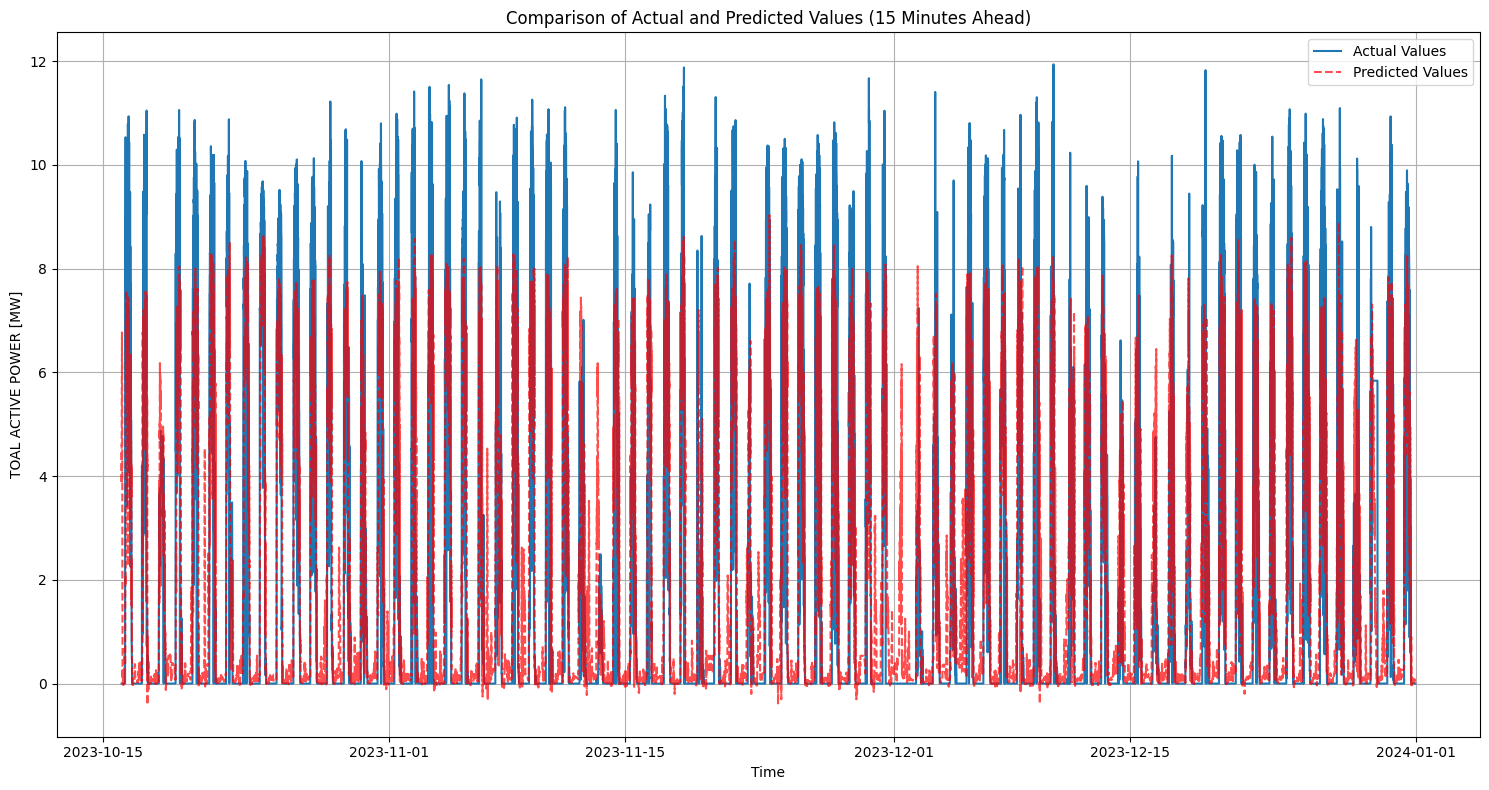

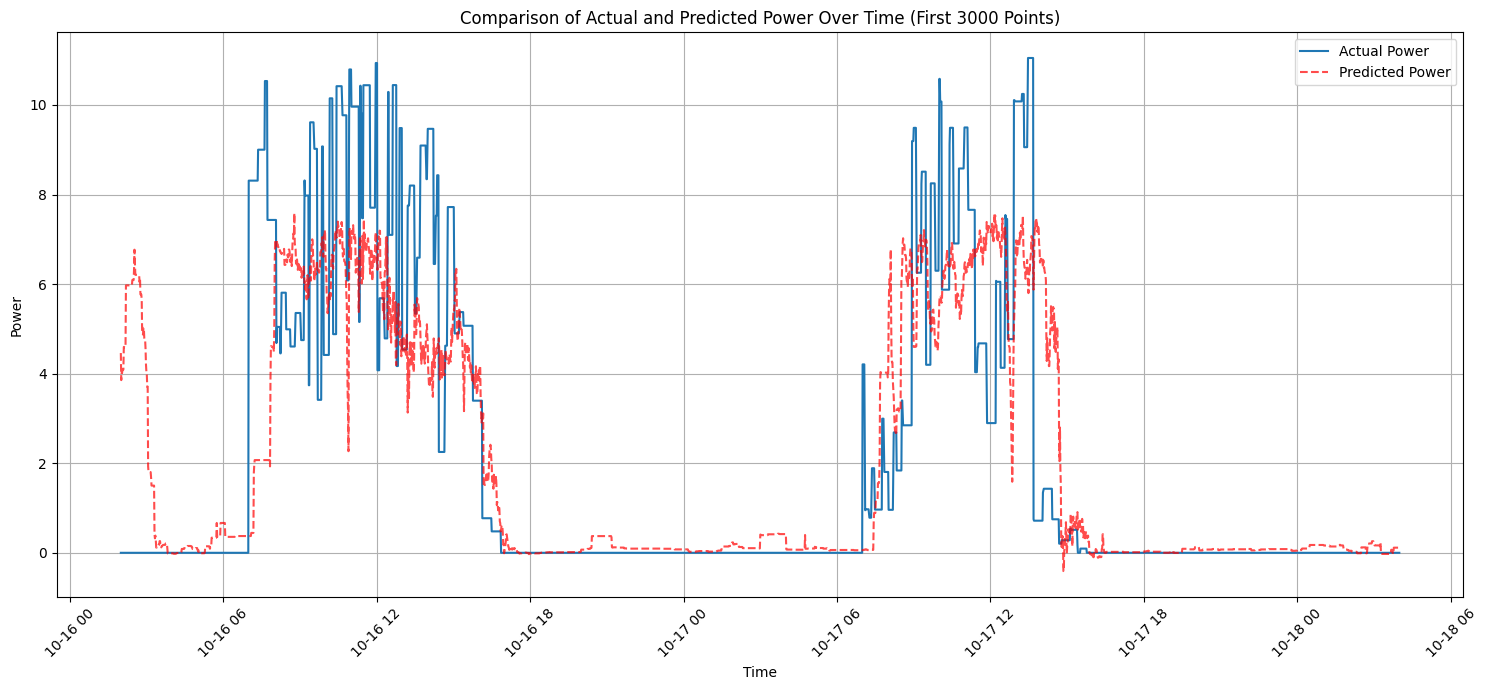

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# Load the training and testing datasets
train_data = pd.read_excel('/content/Train Data set.xlsx', parse_dates=['Time'], index_col='Time')
test_data = pd.read_excel('/content/Test  Data Set.xlsx', parse_dates=['Time'], index_col='Time')

# Ensure data is sorted by time (just in case)
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# Function to create lagged features for supervised learning
def create_lag_features(data, input_columns, output_column, lag_minutes, prediction_step):
    """
    Create lag features and the target column shifted by `prediction_step`.
    """
    df = data.copy()

    # Create lagged features for each input column
    for col in input_columns:
        for lag in range(1, lag_minutes + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # Create target column shifted for prediction
    df['target'] = df[output_column].shift(-prediction_step)

    # Drop rows with NaN values caused by lagging and shifting
    df.dropna(inplace=True)

    return df

# Configuration
input_columns = ['Irradiation', 'Temp', 'Wind', 'Humidity']
output_column = 'TOAL ACTIVE POWER [MW]'
lag_minutes = 120         # Last 15 minutes
prediction_step = 60      # Predicting 15 minutes ahead

# Create lagged features for training and testing datasets
train_lagged = create_lag_features(train_data, input_columns, output_column, lag_minutes, prediction_step)
test_lagged = create_lag_features(test_data, input_columns, output_column, lag_minutes, prediction_step)

# Split into features (X) and target (y)
X_train = train_lagged[[f'{col}_lag_{i}' for col in input_columns for i in range(1, lag_minutes + 1)]].values
y_train = train_lagged['target'].values

X_test = test_lagged[[f'{col}_lag_{i}' for col in input_columns for i in range(1, lag_minutes + 1)]].values
y_test = test_lagged['target'].values

# Train the XGBoost model with additional parameters
model = XGBRegressor(
    objective='reg:squarederror',  # For regression
    eval_metric='rmse',           # Evaluation metric
    n_estimators=50,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=8,                  # Maximum depth of a tree
    subsample=0.8,                # Fraction of samples per tree
    colsample_bytree=0.8          # Fraction of features per tree
)
model.fit(X_train, y_train)


# Test the model
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')

# Visualization: Actual vs Predicted
plt.figure(figsize=(15, 8))
plt.plot(test_lagged.index, y_test, label='Actual Values', linestyle='-', markersize=2)
plt.plot(test_lagged.index, y_pred, label='Predicted Values', linestyle='--', alpha=0.7, color='red')
plt.title('Comparison of Actual and Predicted Values (15 Minutes Ahead)')
plt.ylabel(output_column)
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional plot for first 3000 points
num_points = 3000
test_times = test_lagged.index  # Ensure that test_times is the correct time index for plotting

plt.figure(figsize=(15, 7))
plt.plot(test_times[:num_points], y_test[:num_points], label='Actual Power', linestyle='-', markersize=2)
plt.plot(test_times[:num_points], y_pred[:num_points], label='Predicted Power', linestyle='--', alpha=0.7, color='red')
plt.title('Comparison of Actual and Predicted Power Over Time (First 3000 Points)')
plt.ylabel('Power')
plt.xlabel('Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()